## Unsupservised Learning
From: https://github.com/kanezaki/pytorch-unsupervised-segmentation-tip

In [28]:
%matplotlib inline

#from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
import torch.nn.init
import random

import matplotlib.pyplot as plt
from IPython import display
from time import sleep

In [3]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [4]:
parser = argparse.ArgumentParser(description='PyTorch Unsupervised Segmentation')
parser.add_argument('--scribble', action='store_true', default=False, 
                    help='use scribbles')
parser.add_argument('--nChannel', metavar='N', default=100, type=int, 
                    help='number of channels')
parser.add_argument('--maxIter', metavar='T', default=1000, type=int, 
                    help='number of maximum iterations')
parser.add_argument('--minLabels', metavar='minL', default=3, type=int, 
                    help='minimum number of labels')
parser.add_argument('--lr', metavar='LR', default=0.1, type=float, 
                    help='learning rate')
parser.add_argument('--nConv', metavar='M', default=2, type=int, 
                    help='number of convolutional layers')
parser.add_argument('--visualize', metavar='1 or 0', default=1, type=int, 
                    help='visualization flag')
parser.add_argument('--input', metavar='FILENAME',
                    help='input image file name', required=True)
parser.add_argument('--stepsize_sim', metavar='SIM', default=1, type=float,
                    help='step size for similarity loss', required=False)
parser.add_argument('--stepsize_con', metavar='CON', default=1, type=float, 
                    help='step size for continuity loss')
parser.add_argument('--stepsize_scr', metavar='SCR', default=0.5, type=float, 
                    help='step size for scribble loss')

_StoreAction(option_strings=['--stepsize_scr'], dest='stepsize_scr', nargs=None, const=None, default=0.5, type=<class 'float'>, choices=None, help='step size for scribble loss', metavar='SCR')

In [18]:
args = parser.parse_args(['--input', '/Users/mschoder/Desktop/test_tile5.jpg',
                          '--maxIter', '200',
                          '--minLabels', '2',
                          '--nChannel', '20'])

In [19]:
# CNN model
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, args.nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(args.nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(args.nConv-1):
            self.conv2.append( nn.Conv2d(args.nChannel, args.nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(args.nChannel) )
        self.conv3 = nn.Conv2d(args.nChannel, args.nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(args.nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(args.nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x


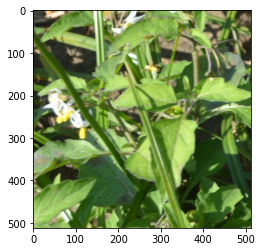

In [20]:
# load image
im = cv2.imread(args.input)
data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
if use_cuda:
    data = data.cuda()
data = Variable(data)

plt.imshow(im)

In [21]:
# load scribble (if used)
if args.scribble:
    mask = cv2.imread(args.input.replace('.'+args.input.split('.')[-1],'_scribble.png'),-1)
    mask = mask.reshape(-1)
    mask_inds = np.unique(mask)
    mask_inds = np.delete( mask_inds, np.argwhere(mask_inds==255) )
    inds_sim = torch.from_numpy( np.where( mask == 255 )[ 0 ] )
    inds_scr = torch.from_numpy( np.where( mask != 255 )[ 0 ] )
    target_scr = torch.from_numpy( mask.astype(np.int) )
    if use_cuda:
        inds_sim = inds_sim.cuda()
        inds_scr = inds_scr.cuda()
        target_scr = target_scr.cuda()
    target_scr = Variable( target_scr )
    # set minLabels
    args.minLabels = len(mask_inds)

In [24]:
# train
model = MyNet( data.size(1) )
if use_cuda:
    model.cuda()
model.train()

# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# scribble loss definition
loss_fn_scr = torch.nn.CrossEntropyLoss()

# continuity loss definition
loss_hpy = torch.nn.L1Loss(size_average = True)
loss_hpz = torch.nn.L1Loss(size_average = True)

HPy_target = torch.zeros(im.shape[0]-1, im.shape[1], args.nChannel)
HPz_target = torch.zeros(im.shape[0], im.shape[1]-1, args.nChannel)
if use_cuda:
    HPy_target = HPy_target.cuda()
    HPz_target = HPz_target.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
label_colours = np.random.randint(255,size=(100,3))

/Users/mschoder/.pyenv/versions/3.7.4/envs/weeding/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: 

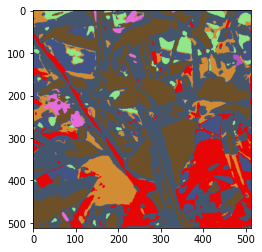

In [36]:
for batch_idx in range(args.maxIter):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.nChannel )

    outputHP = output.reshape( (im.shape[0], im.shape[1], args.nChannel) )
    HPy = outputHP[1:, :, :] - outputHP[0:-1, :, :]
    HPz = outputHP[:, 1:, :] - outputHP[:, 0:-1, :]
    lhpy = loss_hpy(HPy,HPy_target)
    lhpz = loss_hpz(HPz,HPz_target)

    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    if args.visualize:
        im_target_rgb = np.array([label_colours[ c % args.nChannel ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
#         cv2.imshow( "output", im_target_rgb )
#         cv2.waitKey(10)
        
        display.clear_output()
        plt.imshow(im_target_rgb)
        display.display(plt.gcf())


    # loss 
    if args.scribble:
        loss = args.stepsize_sim * loss_fn(output[ inds_sim ], target[ inds_sim ]) + args.stepsize_scr * loss_fn_scr(output[ inds_scr ], target_scr[ inds_scr ]) + args.stepsize_con * (lhpy + lhpz)
    else:
        loss = args.stepsize_sim * loss_fn(output, target) + args.stepsize_con * (lhpy + lhpz)
        
    loss.backward()
    optimizer.step()

    print (batch_idx, '/', args.maxIter, '|', ' label num :', nLabels, ' | loss :', loss.item())

    if nLabels <= args.minLabels:
        print ("nLabels", nLabels, "reached minLabels", args.minLabels, ".")
        break


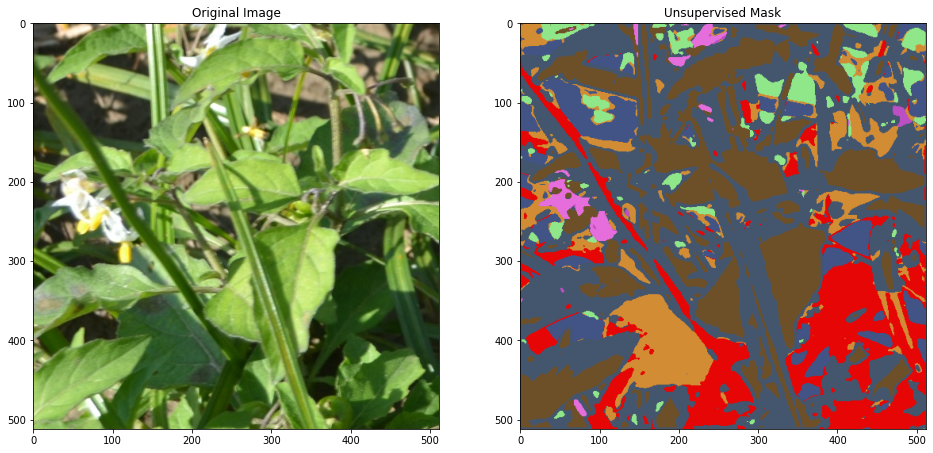

In [46]:
# compare
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(im)

plt.subplot(122)
plt.title("Unsupervised Mask")
plt.imshow(im_target_rgb)

In [ ]:
# save output image
if not args.visualize:
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    im_target_rgb = np.array([label_colours[ c % args.nChannel ] for c in im_target])
    im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
cv2.imwrite( "output.png", im_target_rgb )